# Bevezető példa - Mnist MLP-vel

## 1 Könyvtárak importálása, új sesson létrehozása és felkonfigurálása

Most elrejtjük a GPU-t a Tensorflow elől, így a CPU használatára kényszerítjük.

In [1]:
print('helo')
import os #GPU-t elrejtjuk a Tensorflow meg a Keras elol
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']= ''

helo


Szükséges könyvtárakat beimportáljuk, új Tensorflow session-t inicializálunk, melyet átadunk a Kerasnak

In [3]:
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
session = tf.Session(config=config) # Letrehozunk egy TF session-t a megfelelo mem. korlattal
K.set_session(session) # atadjuk azt a Kerasnak

Importáljunk be olyan köynvtárakat, melyekre a továbbiakban szükségünk lesz:

In [6]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.optimizers import SGD
from keras.datasets import mnist
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from random import sample as RS

Definiáljunk egy függvényt, mely beolvassa az MNIST mintákat és one-hot coding-ra alakítja át az elvárt kimenetetet (ez elengedhetelten, ha több osztályos osztályozási feladatot kívánunk megoldani):

In [7]:
def mintak_mnist():
    (x_tan,y_tan),(x_test,y_test)=mnist.load_data()
    x_tan=x_tan.astype('float32')
    x_test=x_test.astype('float32')
    print(x_tan.shape)
    idx=RS(set(range(y_tan.size)),5)
    print('Mintakepek es a cimkeik: '+str([y for y in y_tan[idx]]))
    
    (f,sf)=plt.subplots(1,5)
    f.set_size_inches(16,6)
    
    for i in range(5):
        img = x_tan[idx[i]]
        sf[i].imshow(img)
    plt.show()
    
    y_tan=to_categorical(y_tan).astype('float32')
    y_test=to_categorical(y_test).astype('float32')   
    return (x_tan,y_tan,x_test,y_test)

Hívjuk is meg a függvényt

(60000, 28, 28)
Mintakepek es a cimkeik: [2, 7, 1, 5, 3]


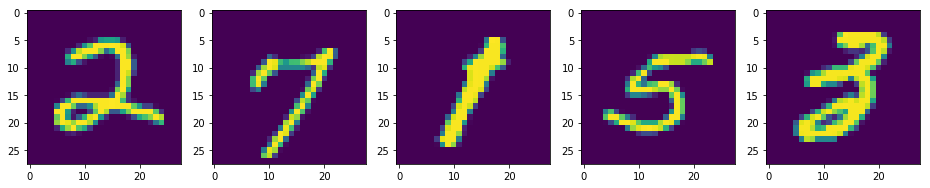

In [8]:
(x_tan,y_tan,x_tst,y_tst)=mintak_mnist() # tanito / teszt mintak lekerese


## 2 rejtett rétegű MLP konstruálása

Definiáljuk először is az MLP architekturáját: első rejtett rétegében 256, másodikban 128 tanh nemlinearitásos neuron szerepel.
Továbbá lefordítjuk:
- definiáljuk a tanításánál későbbiekben alkalmazott optimalizációt
- továbbá meghatározzuk a veszteségfüggvényt, illetve a metrikákat is

In [9]:
def get_MLP(x_p, y_p):
    bem = Input(shape=x_p[0].shape, dtype='float32')
    x = Flatten()(bem)
    x1 = Dense(256, activation='tanh')(x)
    x2 = Dense(128, activation='tanh')(x1)
    y = Dense(y_p[0].size, activation='softmax')(x2)
    
    model=Model(inputs=bem, outputs=y)
    model.compile(optimizer=SGD(lr=0.005, decay=0, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])
    return(model)

Definiáljuk a hálót tanító függvényt is:
A Kereas beépített fit függvényét fogjuk meghívni, továbbá tanulás görbét is rajzolunk.

In [10]:
def tanitas(model, x_tan, y_tan, epn):
    hst=model.fit(x=x_tan, y=y_tan, verbose=1, batch_size=32, epochs=epn, validation_split=0.1)
    
    plt.title('Tanito gorbek')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    epi=np.linspace(1,epn,epn)
    plt.plot(epi, hst.history['loss'], 'b-', epi, hst.history['val_loss'], 'r-')
    plt.legend(['tanito', 'validacios'], loc='upper left')
    plt.show()
    return model

Hívjuk meg az előző két függvényt, hogy létrehozzuk és betanítsuk az MLP-t.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
None
Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - 5s 93us/step - loss: 0.9

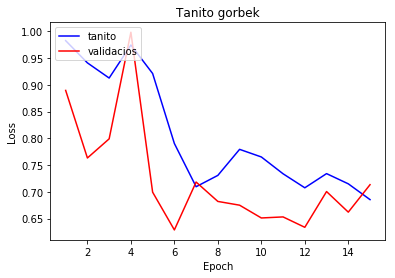

In [12]:
mlp=get_MLP(x_tan,y_tan)
print(mlp.summary())
mlp=tanitas(mlp,x_tan,y_tan,15)

## Háló elmentése, betöltése

Írjuk meg a háló kimentéséhez, valamint visszatöltéséhez szükséges függvényeket, illetve importáljuk be a json file-ból model objektumot konvertáló Keras függvényt.

In [13]:
from keras.models import model_from_json

def halo_mentes(model,nev):
    model_json=model.to_json()
    with open(nev+'.json','w') as json_file:
        json_file.write(model_json)
    model.save_weights(nev+'.h5')
    

def halo_betoltes(nev):
    json_file=open(nev+'.json','r')
    model_json=json_file.read()
    json_file.close()
    model=model_from_json(model_json)
    model.load_weights(nev+'.h5')
    
    return(model)

Hívjuk meg a két függvényt:

In [14]:
halo_mentes(mlp, 'mlp_mnist')
mlp=halo_betoltes('mlp_mnist')

## Háló tesztelése

### Top3 Accuracy-val való bővítése a háló metrikáinak

Definiáljunk a kiértékelést végző függvényt:

In [45]:
from sklearn.metrics import confusion_matrix

def teszt(halo, x_test, y_test):
    #halo.compile(optimizer=SGD(lr=0.005, decay=0, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])
    tmp=halo.evaluate(x_test,y_test)
    print(tmp)
    
    y_pred=np.argmax(halo.predict(x_test),axis=1)
    print('Confusion Matrix:')
    print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))
    print()
    print('Loss:'+str(tmp[0])+'; Acc:'+str(tmp[1])+'; Top3Acc:'+str(tmp[2]))
    print()
    return({'loss':tmp[0], 'acc':tmp[1], 'top3acc':tmp[2]})


Hívjuk is meg a tesztpontokra.

In [34]:
teszt(mlp,x_tst,y_tst)

10000/10000 [==============================] - 0s 39us/step
Confusion Matrix:
[[ 792    1   21   15    4  115   18    1    5    8]
 [   0 1105    8    3    0    0    2    4   11    2]
 [   7    5  906   35    7    7   18    9   22   16]
 [  31   17   61  652    1   62    5   11  152   18]
 [   2   22   24    0  597    1    6   20   40  270]
 [ 100    8   24   89   13  529   19   14   66   30]
 [  22    8  137    4   19   27  709    0   12   20]
 [  14   33   87    3   11    4    0  678   79  119]
 [  16   23   68   41   16   57    5   25  644   79]
 [   7   23   12    7  126    8    6   52   80  688]]



IndexError: list index out of range

Vegyünk fel egy új metrikát, mely azt méri, hogy egy adott mintához tartozó elvárt kimenet, a háló által adott bemenethez 3 legnagyobb konfidenciával taksált kimeneti osztály egyikének a tagja. Ennek használatához újra kell fordítanunk a hálót.

In [46]:
from keras.metrics import top_k_categorical_accuracy

def inTop3(x,y):
    return(top_k_categorical_accuracy(x,y,k=3))

mlp.compile(optimizer=SGD(lr=0.01, decay=0, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy', inTop3])


In [47]:
mlp.compile(optimizer=SGD(lr=0.01, decay=0, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy', inTop3])
teszt(mlp,x_tst,y_tst)

10000/10000 [==============================] - 0s 43us/step
[0.7539870841026306, 0.73, 0.9456]
Confusion Matrix:
[[ 792    1   21   15    4  115   18    1    5    8]
 [   0 1105    8    3    0    0    2    4   11    2]
 [   7    5  906   35    7    7   18    9   22   16]
 [  31   17   61  652    1   62    5   11  152   18]
 [   2   22   24    0  597    1    6   20   40  270]
 [ 100    8   24   89   13  529   19   14   66   30]
 [  22    8  137    4   19   27  709    0   12   20]
 [  14   33   87    3   11    4    0  678   79  119]
 [  16   23   68   41   16   57    5   25  644   79]
 [   7   23   12    7  126    8    6   52   80  688]]

Loss:0.7539870841026306; Acc:0.73; Top3Acc:0.9456



{'loss': 0.7539870841026306, 'acc': 0.73, 'top3acc': 0.9456}

Végezetül töröljük a létrehozott session-t, ezáltal felszabadítva a GPU memóriát

In [51]:
K.clear_session()

Copyright (c) 2018 Hadházi Dániel, BME-MIT